# Preprocessing

In [147]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
%autoreload 2

In [149]:
import torch

In [150]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [413]:
connection = Connection()
# Get client
client = connection.get_client()

In [414]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [415]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [416]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W08... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W10... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W11... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W15... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W18... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_

734

In [417]:
summarize_null(df_all_wells_preprocessed)

qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
well_code    0
dhp          0
dht          0
whp          0
wht          0
choke        0
dcp          0
well_id      0
wc_mpfm      0
time_idx     0
dtype: int64

In [418]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_all_wells_preprocessed, test_size=0.2)
len(df_train), len(df_val), len(df_test)

(509, 83, 142)

In [419]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.4454


In [420]:
model.score_physics(df_test)

{'W06': {'qo': {'r2': 0.4282394466532543,
   'mae': 21.025572549609993,
   'rmse': 24.60510405584853,
   'mape (%)': 21.975487860506433,
   'mpe (%)': 16.289548884245782},
  'qw': {'r2': -0.35442208975501854,
   'mae': 0.12903037394365227,
   'rmse': 0.16249333981288278,
   'mape (%)': 17639.55581840543,
   'mpe (%)': 17583.146211347175},
  'qg': {'r2': 0.729403482428945,
   'mae': 1756.2910809886216,
   'rmse': 2070.661210942337,
   'mape (%)': 12.578468549390614,
   'mpe (%)': 3.5950545922557087},
  'wgr': {'r2': -3.789023399054651,
   'mae': 1.356614168329823e-05,
   'rmse': 1.5004824108854706e-05,
   'mape (%)': 74.28676996947488,
   'mpe (%)': -74.28676996947488},
  'gor': {'r2': -6.750418792445813,
   'mae': 11.99856787448636,
   'rmse': 15.351368579584344,
   'mape (%)': 9.6242782895186,
   'mpe (%)': -9.6242782895186}},
 'W08': {'qo': {'r2': -0.03246343718308631,
   'mae': 4.226029471409601,
   'rmse': 6.7933541363623435,
   'mape (%)': 12.29173722480843,
   'mpe (%)': -7.21162

In [421]:
model.score_hybrid(df_test)

{'W06': {'qo': {'r2': 0.8537679113128548,
   'mae': 10.660194637719462,
   'rmse': 12.443411201449916,
   'mape (%)': 8.94000447790884,
   'mpe (%)': -1.3486740557027133},
  'qw': {'r2': -0.47003429197217783,
   'mae': 0.0957245476513644,
   'rmse': 0.16928648355229653,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.9290441212330635,
   'mae': 899.0459652130673,
   'rmse': 1060.332658531561,
   'mape (%)': 6.21282142993937,
   'mpe (%)': -2.053404141830093},
  'wgr': {'r2': -6.597719495065025,
   'mae': 1.7611824659725264e-05,
   'rmse': 1.8899445270971217e-05,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -2.1022063966490783,
   'mae': 7.107141990112948,
   'rmse': 9.712250124027575,
   'mape (%)': 5.791931454885052,
   'mpe (%)': -0.1276240559678359}},
 'W08': {'qo': {'r2': 0.28943741139674395,
   'mae': 3.3193634832336265,
   'rmse': 5.6357028131522915,
   'mape (%)': 12.229811266533776,
   'mpe (%)': -7.149702770082765},
  'qw': {'r2': 0.88039311590336

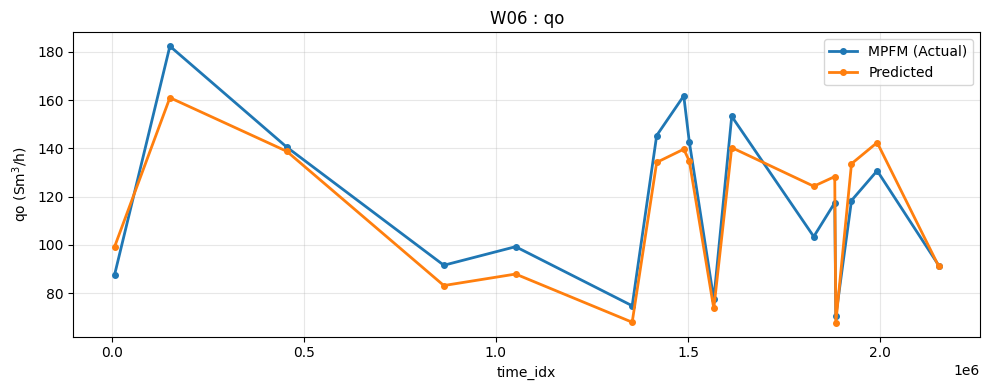

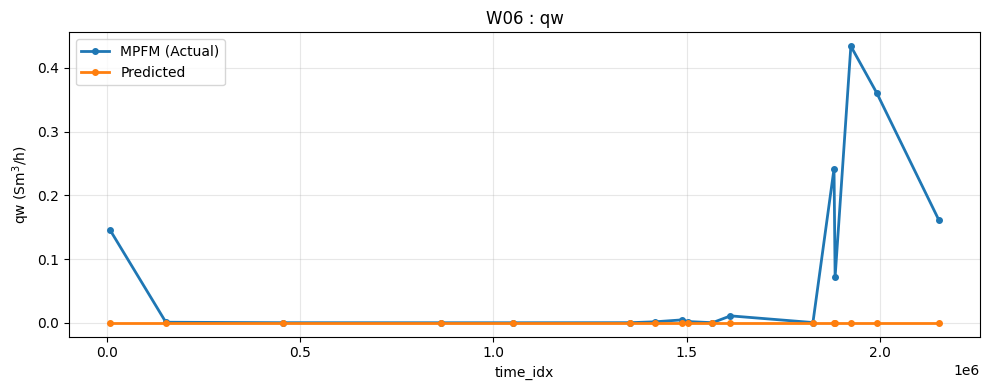

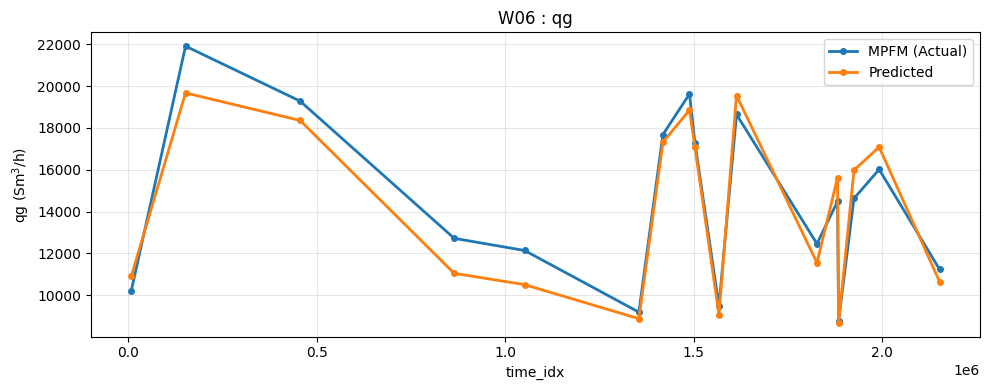

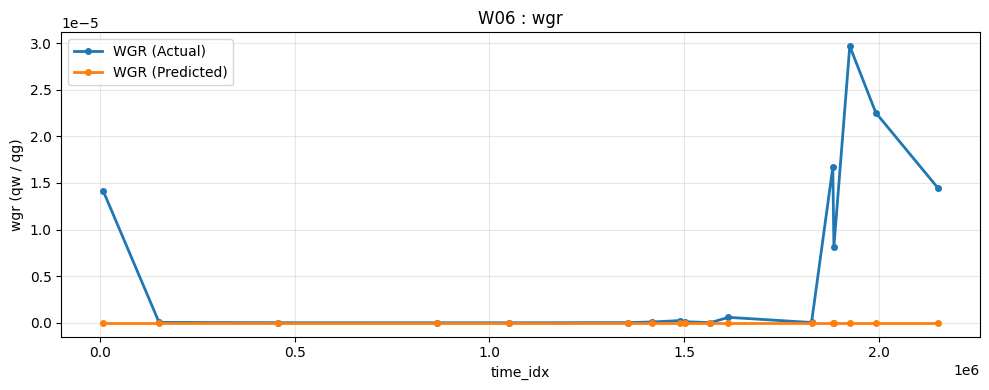

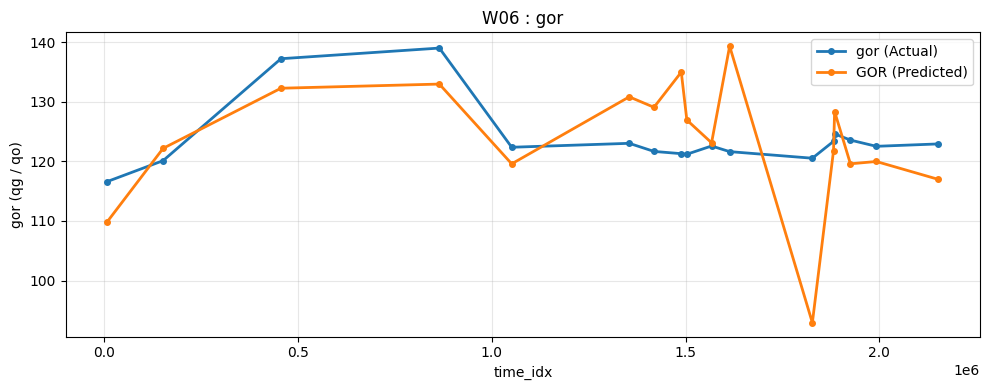

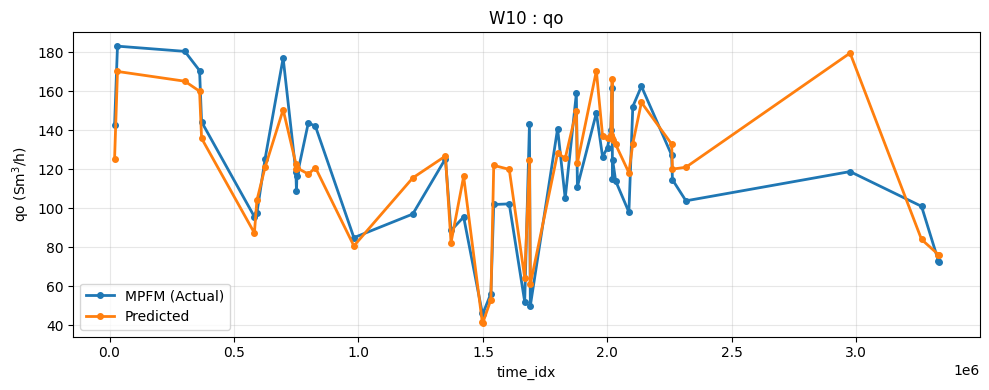

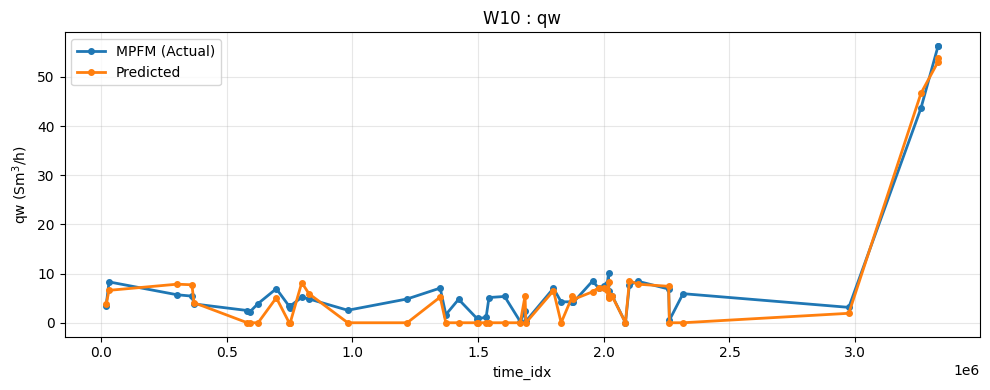

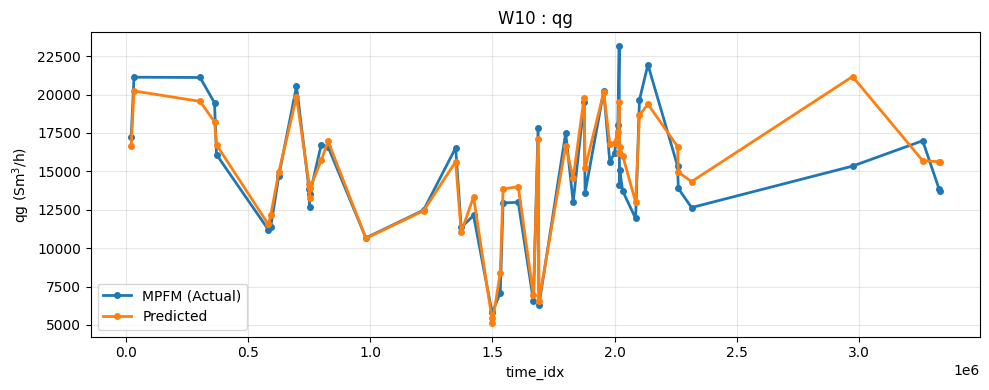

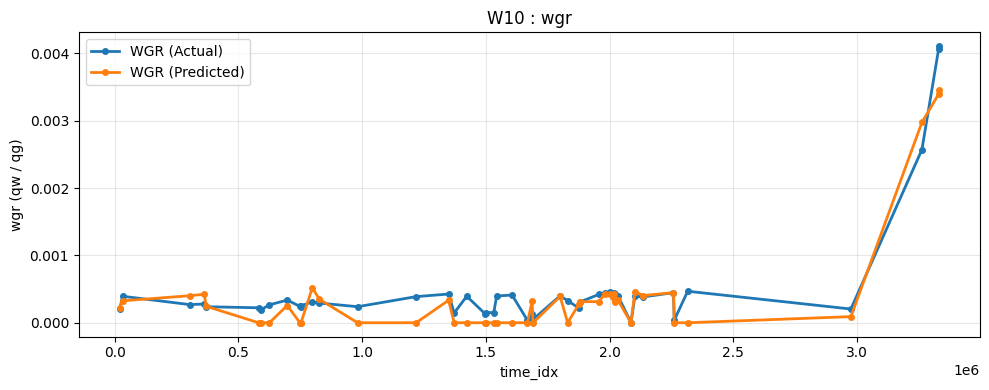

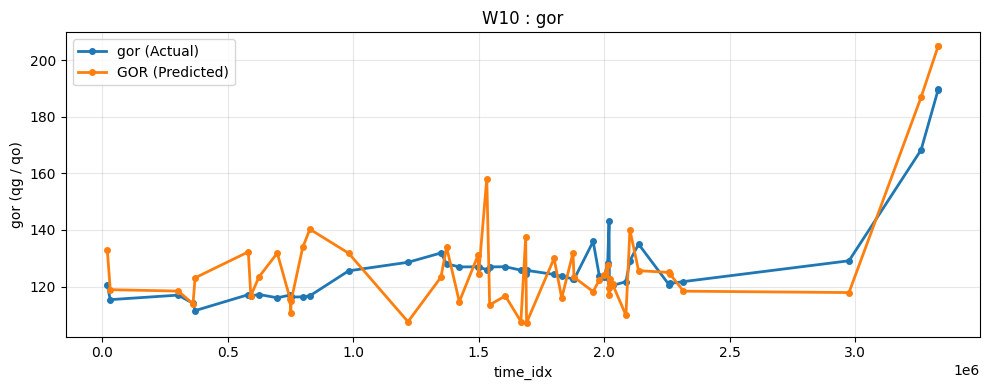

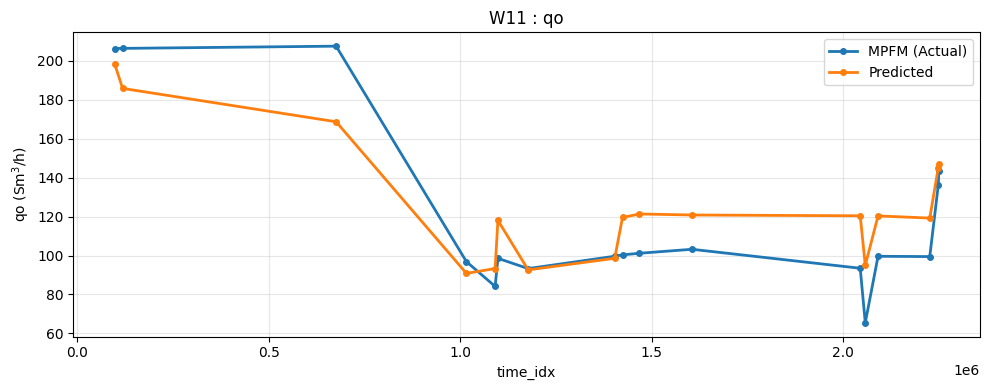

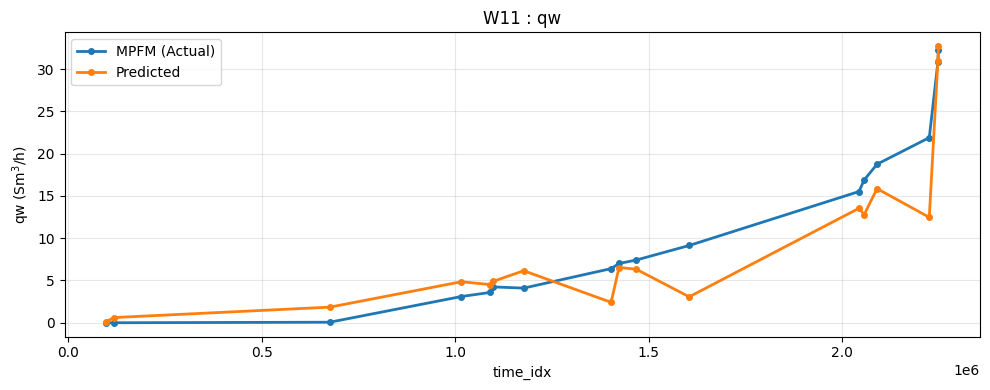

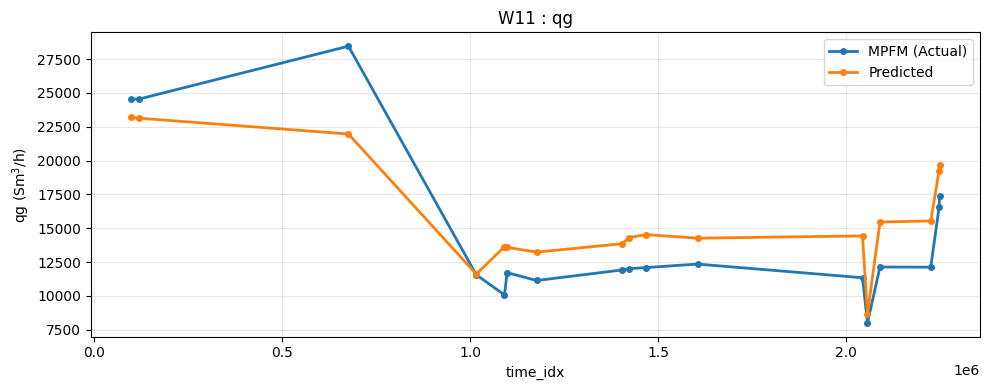

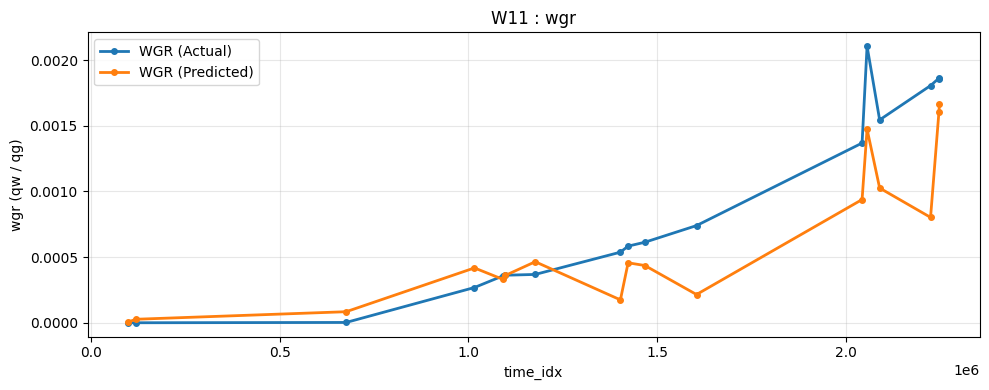

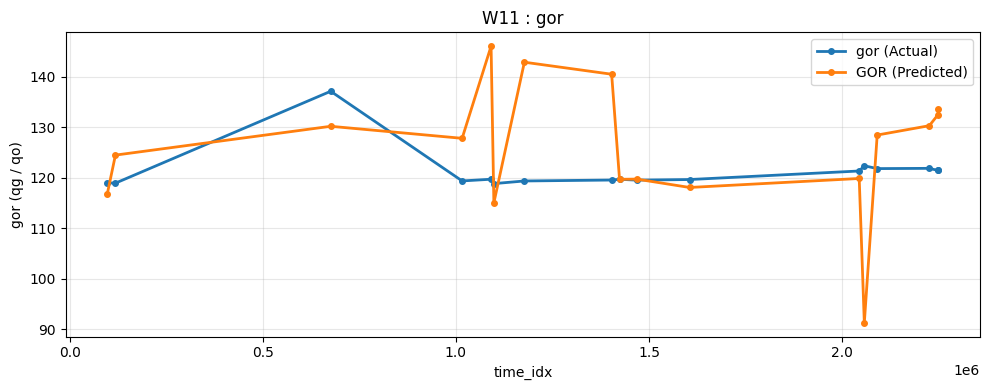

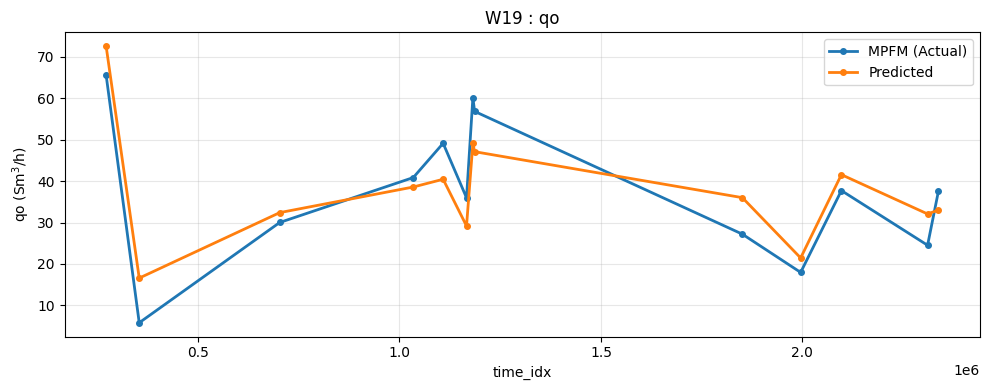

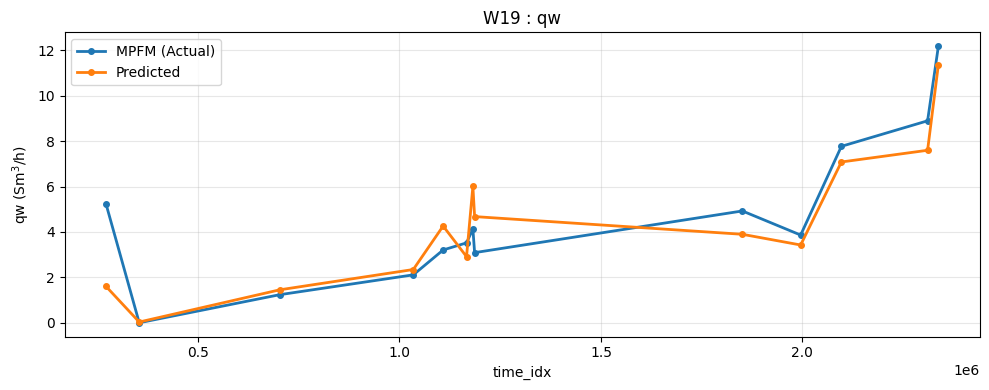

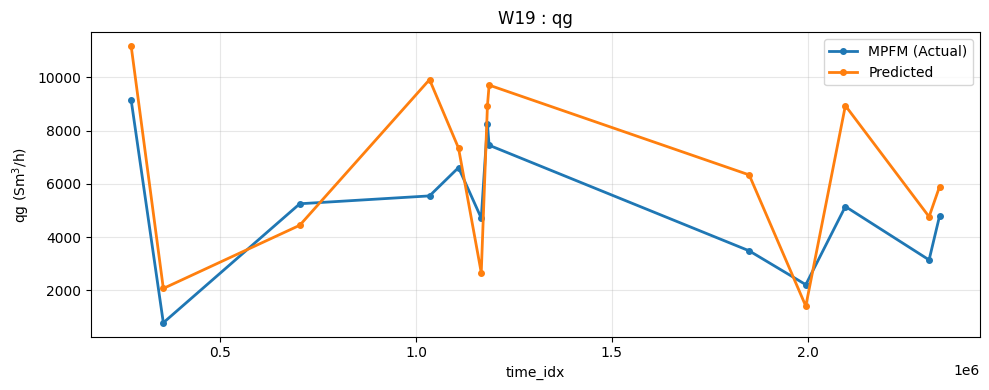

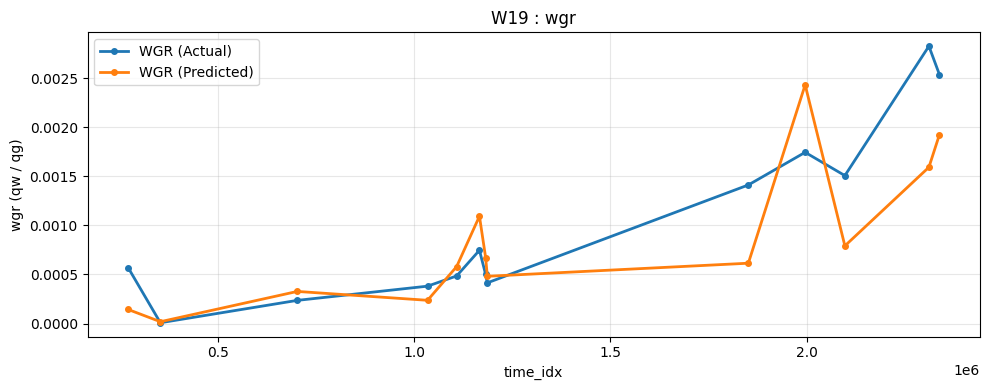

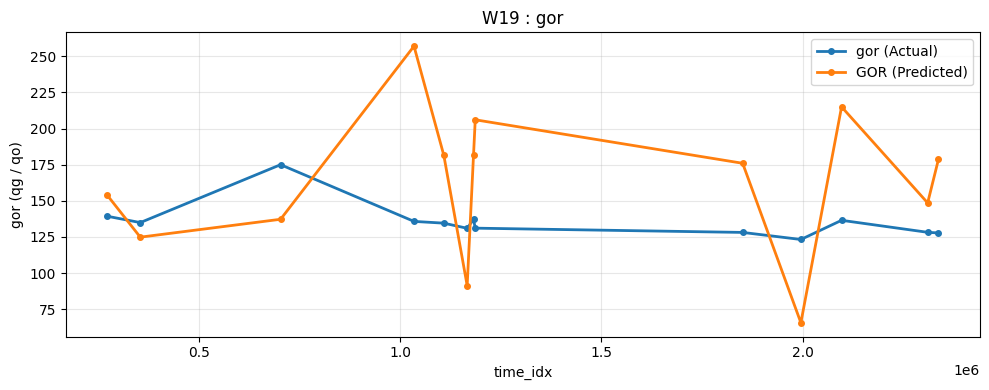

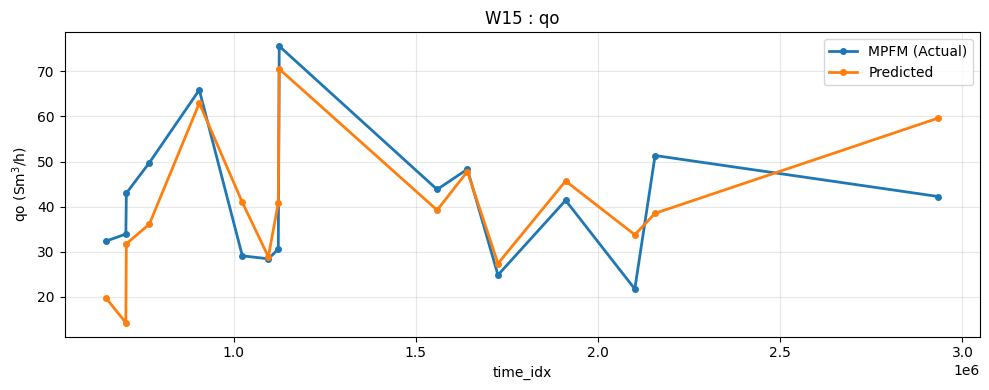

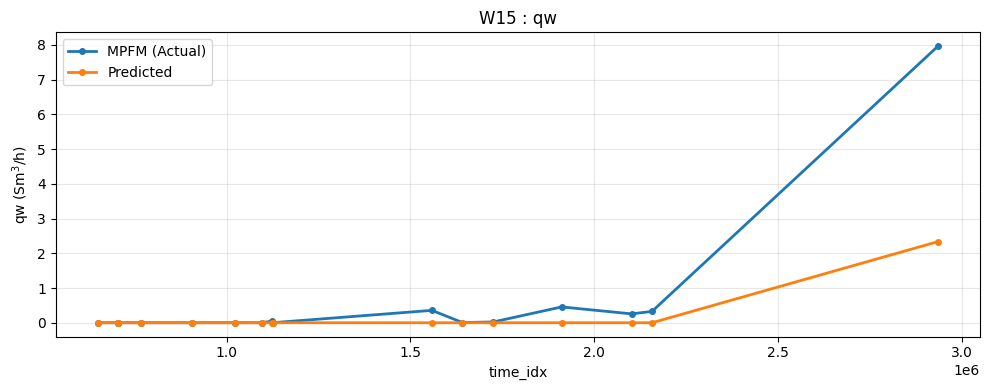

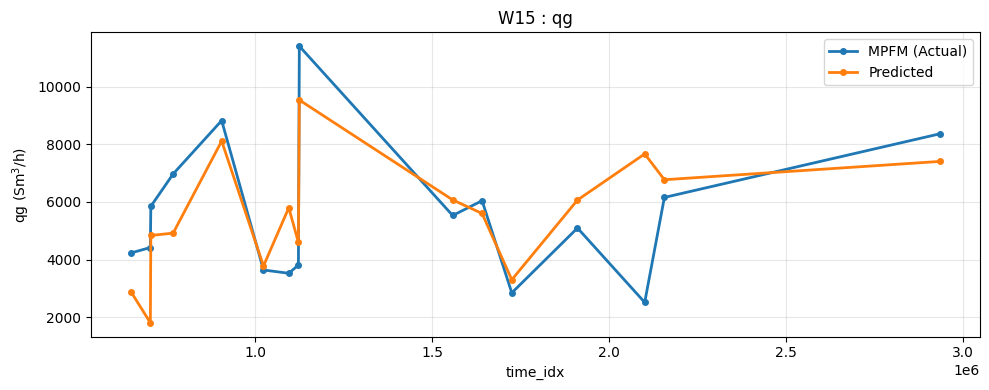

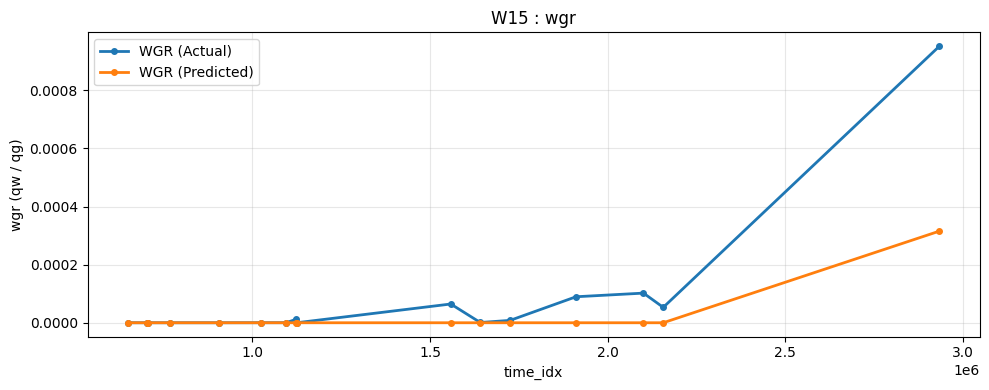

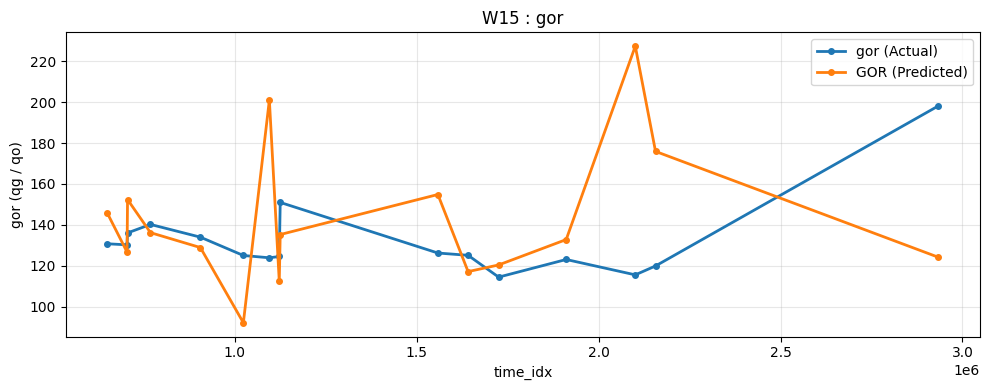

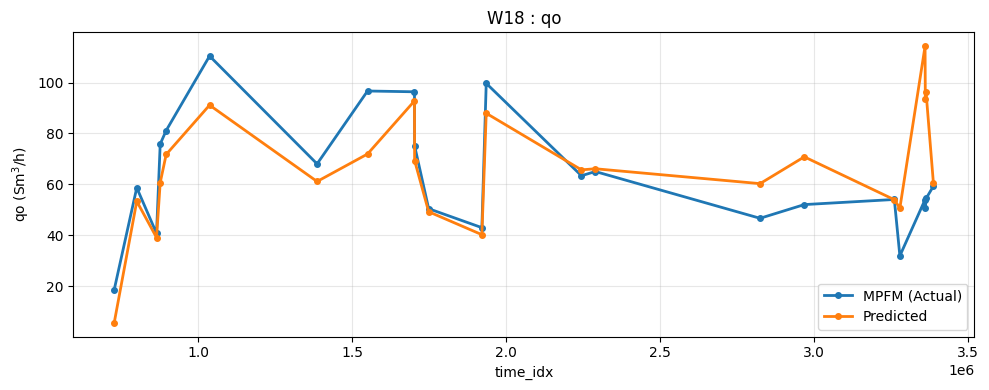

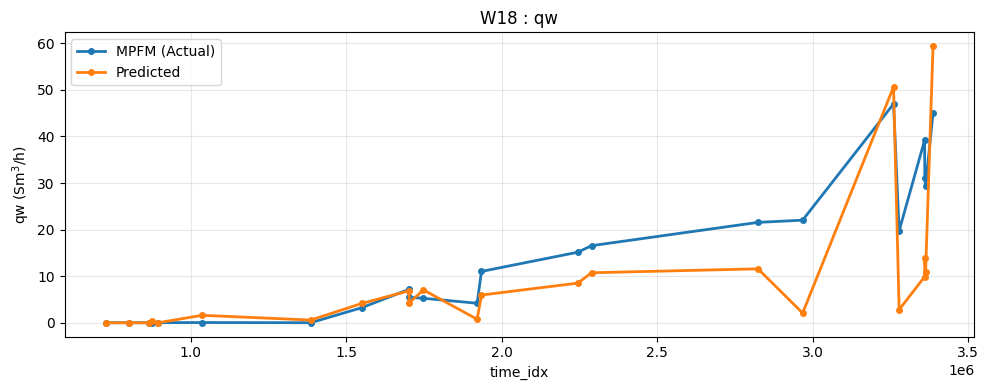

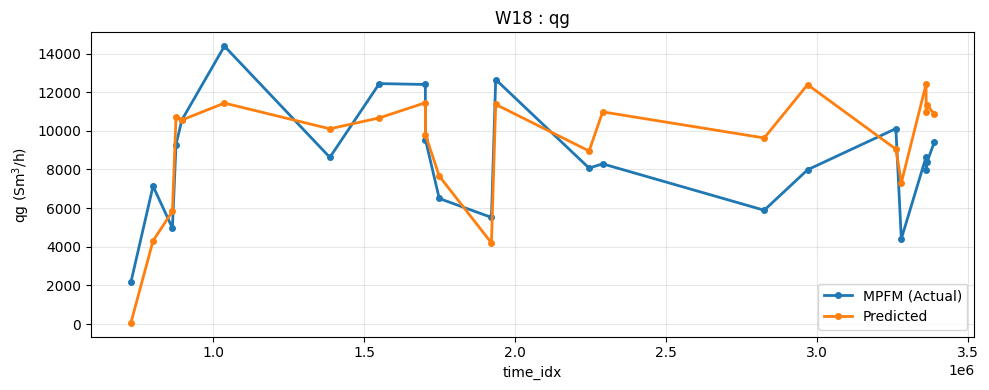

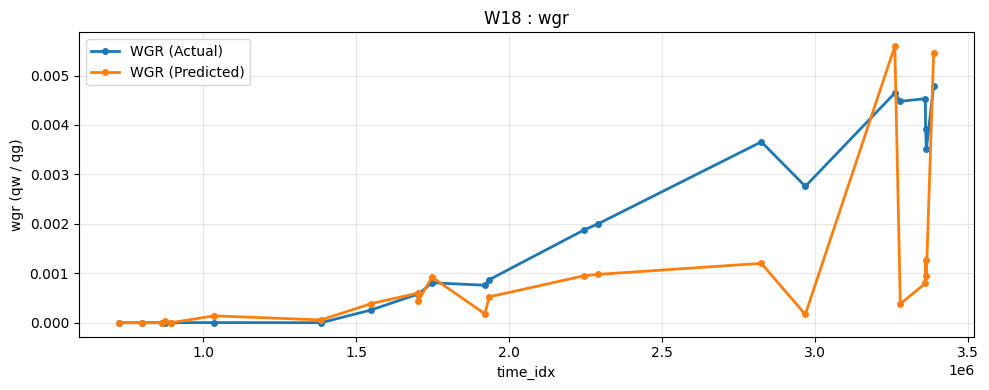

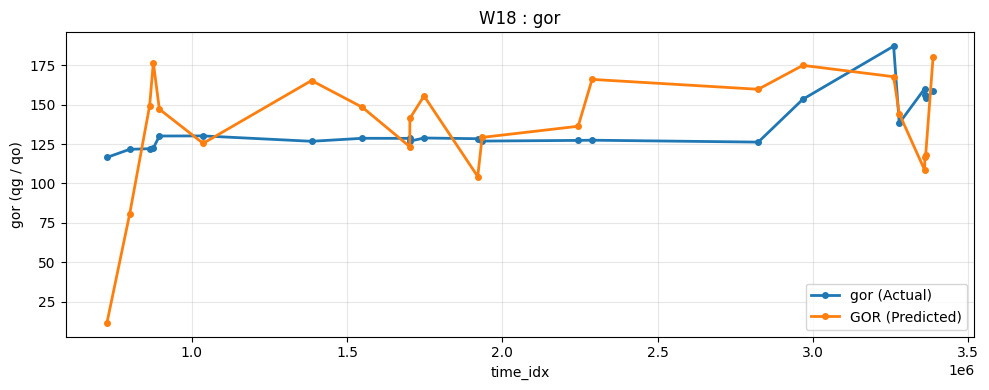

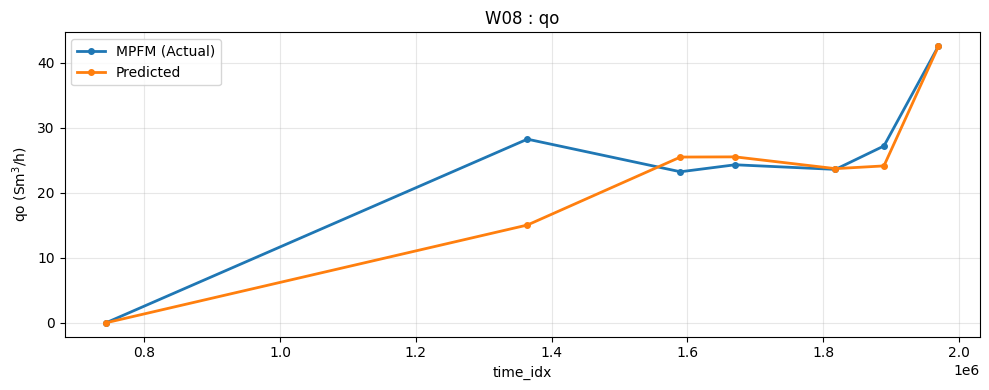

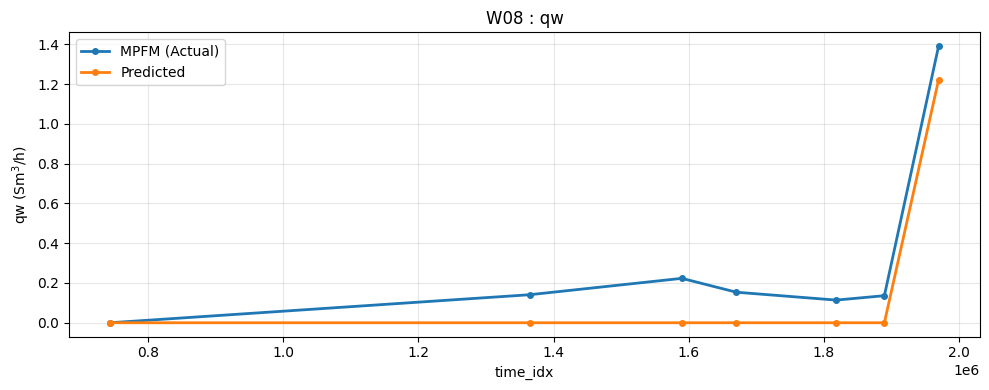

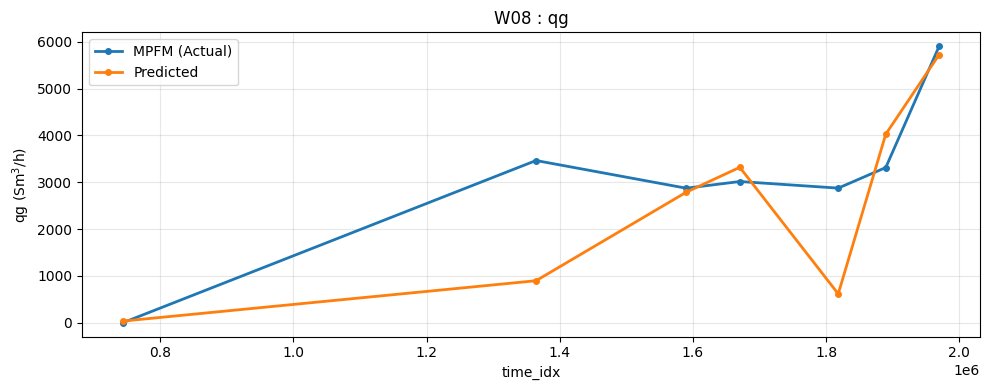

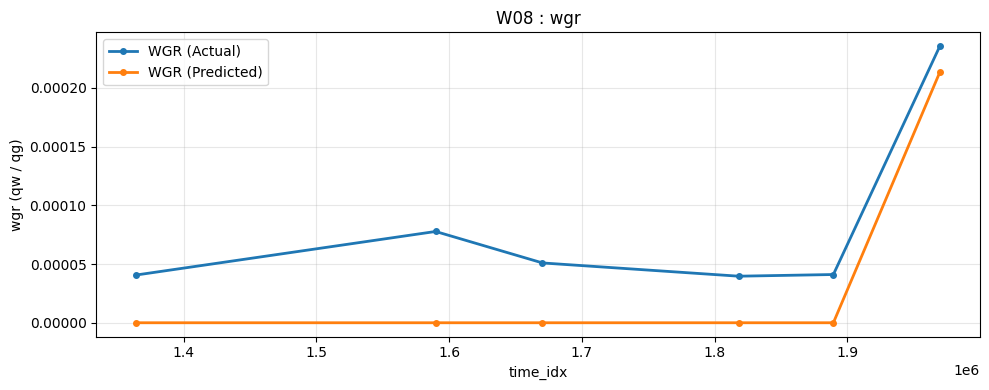

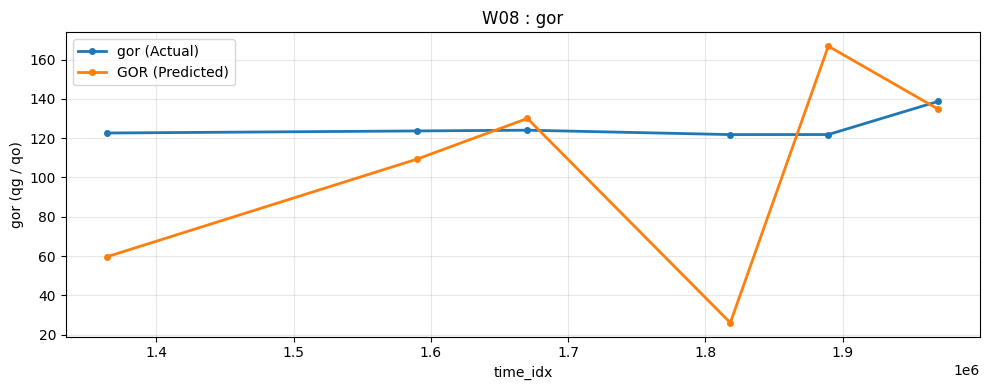

In [422]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)